In [1]:
from google.colab import files
!pip install kaggle
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [2]:
!kaggle competitions download -c happy-whale-and-dolphin

100% 57.7G/57.7G [08:05<00:00, 148MB/s]
100% 57.7G/57.7G [08:05<00:00, 128MB/s]


In [3]:
#extracte data from zipfile
import zipfile
zf = "/content/happy-whale-and-dolphin.zip"
target_dir = "/content/dataset/dolphin"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)



# Import libraries.


In [2]:
# Core
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import os
import cv2
#tesor fow & keras
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2     
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input
from keras.models import Sequential, Model
from keras.layers import Conv2D,GlobalMaxPooling2D
from tensorflow.keras.applications import  Xception,VGG16,InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#cnn
from tensorflow.keras import datasets, layers, models

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.engine.base_layer import Layer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
seed = 42
np.random.seed =seed

In [5]:
image_path = '/content/dataset/dolphin/'


# Bussiness Task
Developing  a model to match individual whales and dolphins by unique—but often subtle—characteristics of their natural markings. 






# Data Preperation.
1.   read csv file to get all data about train image 
2.   Check Null data 
3.   clear duplicate data





In [6]:
train_df = pd.read_csv(image_path+'train.csv')
train_df.head(20)

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
5,000a8f2d5c316a.jpg,bottlenose_dolphin,b9907151f66e
6,000be9acf46619.jpg,beluga,afb9b3978217
7,000bef247c7a42.jpg,humpback_whale,444d8894ccc8
8,000c3d63069748.jpg,beluga,df94b15285b9
9,000c476c11bad5.jpg,bottlenose_dolphin,b11b2404c7e3


In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51033 entries, 0 to 51032
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          51033 non-null  object
 1   species        51033 non-null  object
 2   individual_id  51033 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [8]:
train_df.shape

(51033, 3)

In [9]:
train_df.isnull().sum().sort_values(ascending=False)

image            0
species          0
individual_id    0
dtype: int64

In [10]:
train_df.drop_duplicates(inplace=True)

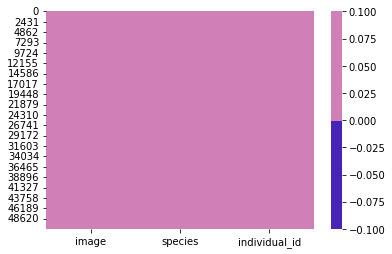

In [11]:
cols =train_df.columns
colours = ['#4624b8', '#d080b6'] # specify the orange  - yellow is missing. blue is not missing.
sns.heatmap(train_df[cols].isnull(), cmap=sns.color_palette(colours))

**Get Unique data for each column in  Data Frame** 

In [12]:
sorted(train_df['species'].unique())

['beluga',
 'blue_whale',
 'bottlenose_dolphin',
 'bottlenose_dolpin',
 'brydes_whale',
 'commersons_dolphin',
 'common_dolphin',
 'cuviers_beaked_whale',
 'dusky_dolphin',
 'false_killer_whale',
 'fin_whale',
 'frasiers_dolphin',
 'globis',
 'gray_whale',
 'humpback_whale',
 'kiler_whale',
 'killer_whale',
 'long_finned_pilot_whale',
 'melon_headed_whale',
 'minke_whale',
 'pantropic_spotted_dolphin',
 'pilot_whale',
 'pygmy_killer_whale',
 'rough_toothed_dolphin',
 'sei_whale',
 'short_finned_pilot_whale',
 'southern_right_whale',
 'spinner_dolphin',
 'spotted_dolphin',
 'white_sided_dolphin']

From above we found that there are some coliumn name need to be corrected.

In [13]:
train_df['species'].replace({
                          "pilot_whale": "short_finned_pilot_whale",
                          "globis": "short_finned_pilot_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin",
                          "kiler_whale": "killer_whale"}, inplace=True)


In [14]:
total_train =train_df['species'].count()
totalspecies=train_df['species'].nunique()
totalindividual_id= train_df['individual_id'].nunique()
print(f'Total train images         : {total_train}')
print(f'Total train species        : {totalspecies}')
print(f'Total train individualId   : {totalindividual_id}')

Total train images         : 51033
Total train species        : 26
Total train individualId   : 15587


In [119]:
labels = list(train_df['individual_id'].unique())

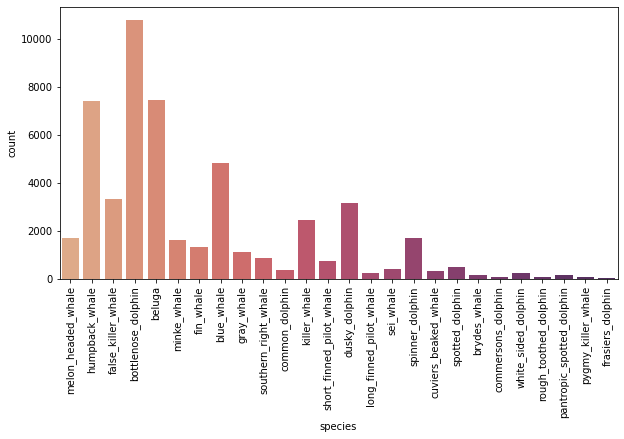

In [61]:
plt.figure(figsize=(10,5))
sns.countplot(x='species',data=train_df,palette='flare')
plt.xticks(rotation=90)
plt.show()

In [65]:
import plotly.express as px
fig = px.sunburst(train_df,path=['species'])
fig.show()

# Whale analysis and Visualization 🐳
1.  collect all types of whales 
2.  collect all walles data  
3.  whale statistics 
4.  whales Visualize 

In [108]:
# get all wales types
allwales = [data for data in train_df['species'].unique()  if not "dolphin" in data and  not "dolpin" in data]
#get all data for each specific type
whales_df = train_df[train_df['species'].isin(allwales)]
whales_df.head(10)

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
6,000be9acf46619.jpg,beluga,afb9b3978217
7,000bef247c7a42.jpg,humpback_whale,444d8894ccc8
8,000c3d63069748.jpg,beluga,df94b15285b9
10,001001f099519f.jpg,minke_whale,19fbb960f07d
11,00103cbe9d25ce.jpg,fin_whale,180c0ab04dcd
13,00167e8375c967.jpg,beluga,0ad50d0d9b06


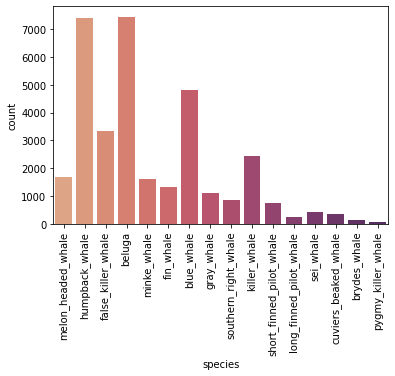

In [100]:
sns.countplot(x='species',data=whales_df,palette='flare')
plt.xticks(rotation=90)
plt.show()

In [110]:
import plotly.express as px
fig = px.sunburst(whales_df,path=['species'])
fig.show()

**whale statistics**

In [101]:
total = len(allwales)
print(f' total train whale is         :    {total}')
whale_images = whales_df['image'].nunique()
print(f' train whale images  is       : {whale_images}')
whale_ids=whales_df['individual_id'].nunique()
print(f' train whale individualId  is : {whale_ids}')

 total train whale is         :    16
 train whale images  is       : 34038
 train whale individualId  is : 10395


Notes 
 

*   humpback_whale & beluga has most count of image in data set 
*   pygemy_killer_wall has low image in whale data set
*  there are variation of image of whaels between its types.



# Dolphin analysis and Visualization 🐬
1.  collect all types of Dolphin 
2.  collect all Dolphin data  
3.  Dolphin statistics 
4.  Dolphin Visualize 

In [103]:
# get all dolphin types
all_dolphine = [data for data in train_df['species'].unique()  if  "dolphin" in data or  "dolpin" in data]
#get all data for each specific type
dolphin_df = train_df[train_df['species'].isin(all_dolphine)]
dolphin_df.head(10)

,image,species,individual_id
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
5,000a8f2d5c316a.jpg,bottlenose_dolphin,b9907151f66e
9,000c476c11bad5.jpg,bottlenose_dolphin,b11b2404c7e3
12,00144776eb476d.jpg,bottlenose_dolphin,b9907151f66e
14,00177f3c614d1e.jpg,bottlenose_dolphin,812be36c2aef
15,0017b3749cd769.jpg,bottlenose_dolphin,445270d9ad52
27,0028f6fa123686.jpg,bottlenose_dolphin,956562ff2888
30,002e00960cec44.jpg,common_dolphin,e943980b7a98
37,0039599b58fc80.jpg,bottlenose_dolphin,e69d5f9f8d1e
41,003e374b59c0e1.jpg,dusky_dolphin,456bb79da64c


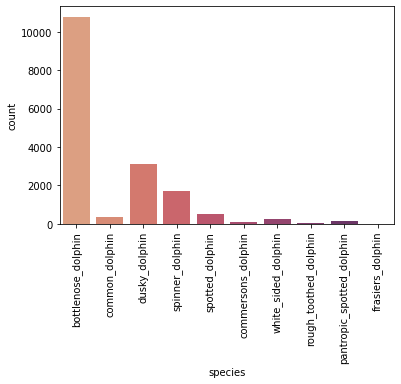

In [104]:
sns.countplot(x='species',data=dolphin_df,palette='flare')
plt.xticks(rotation=90)
plt.show()

In [111]:
import plotly.express as px
fig = px.sunburst(dolphin_df,path=['species'])
fig.show()

In [105]:
total = len(all_dolphine)
print(f' total train Dolphin is         :    {total}')
dolphin_images = dolphin_df['image'].nunique()
print(f' train dolphin images  is       : {dolphin_images}')
whale_ids=dolphin_df['individual_id'].nunique()
print(f' train dolphin individualId  is : {whale_ids}')

 total train Dolphin is         :    10
 train dolphin images  is       : 16995
 train dolphin individualId  is : 5192


Notes 
 

*   humpback_whale bottlenose_dolphin of image in data set .
*   images of dolphine types  is very low which mean that it is difficult to diffreniate between dopline types so we need to increase its images 



# loading images  🐬vs 🐳

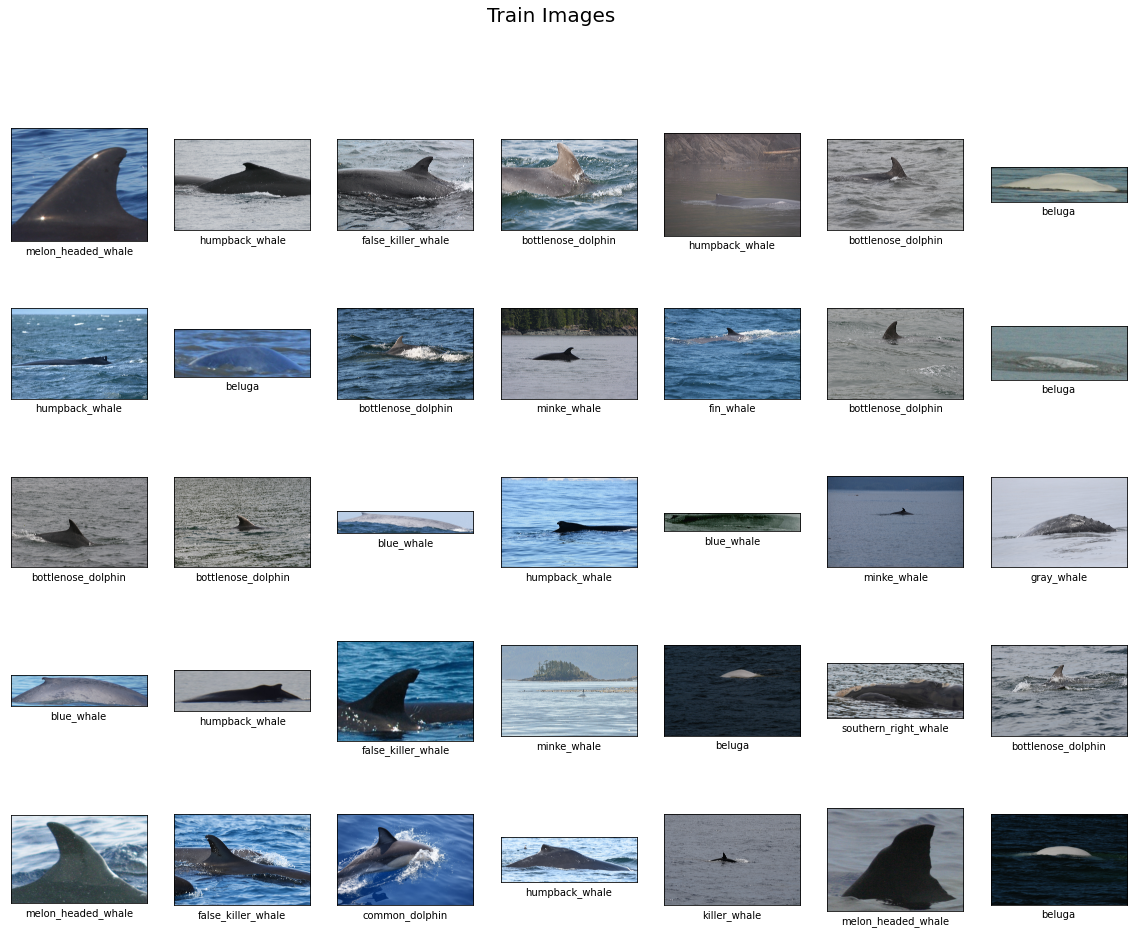

In [116]:

plt.figure(figsize=(20,15))
plt.suptitle("Train Images", fontsize=20)
path =image_path+'/'+'train_images/'
counter =0
for i,img in enumerate(train_df['image'])  :
        plt.subplot(5,7,i+1)
        full_image= plt.imread(path+img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(train_df['species'][i])
        plt.imshow(full_image, cmap=plt.cm.binary) 
        if i == 34:
            break

# Buliding CNN Model

**i will use Data augmentation,as it  is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points.** 



In [130]:
batch_size = 64
#create image generator for images 
image_gen = ImageDataGenerator(
                                 rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.5,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  fill_mode='nearest',
                                   horizontal_flip=True,
                                   rotation_range = 20,
                               validation_split=0.2 
                               )

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(  
                                   rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.5,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  fill_mode='nearest',
                                   horizontal_flip=True,
                                   rotation_range = 20,
                                   validation_split=0.2)        
train = image_gen.flow_from_dataframe(
      train_df,
      path,
      x_col='image',
      y_col='individual_id',
      target_size=(64,64),
      class_mode='categorical',
      shuffle=True, 
      batch_size=batch_size,
      labels =labels,
      subset = "training"
      )
validate = test_data_gen.flow_from_dataframe(
      train_df,
      path,
      x_col='image',
      y_col='individual_id',
      target_size=(64,64),
      class_mode='categorical',
      shuffle=True, 
      batch_size=batch_size,
      subset = "validation",
      labels =labels
      )


Found 40827 validated image filenames belonging to 15587 classes.
Found 10206 validated image filenames belonging to 15587 classes.


In [131]:
# get shape of train data 
for train_img , train_label in train :
    print('image shape ',train_img.shape)
    print('label  shape ',train_label.shape)
    break 

image shape  (64, 64, 64, 3)
label  shape  (64, 15587)


In [132]:
# get shape of train data 
for v_img , v_label in validate :
    print('image shape ',v_img.shape)
    print('label  shape ',v_label.shape)
    break 

image shape  (64, 64, 64, 3)
label  shape  (64, 15587)


In [133]:
cnn_model = Sequential()
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(64,(3,3),padding ='Same',activation = 'relu',input_shape=(64,64,3)))
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(64,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(128,(3,3),padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(layers.Conv2D(128,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(layers.Conv2D(256,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(BatchNormalization())
cnn_model.add(layers.Conv2D(256,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(BatchNormalization())
cnn_model.summary()
# cnn_model.add(Dropout(0.2))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)       

In [134]:

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(1024, activation='relu'))
cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.7))
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.3))
cnn_model.add(layers.Dense(15587, activation ='softmax'))
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)       

In [135]:
cnn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

  **1-Defining Callbacks**

*   A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)


**2-Reduce Learning Rate on Plateau**
*   Is used to reduce the learning rate when a metric has stopped improving.



In [136]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [138]:
# Training model
n_training_samples = len(train)
n_validation_samples = len(validate)
history = cnn_model.fit(
    train,
    epochs=100,
    validation_data=validate,
    validation_steps=n_validation_samples//batch_size,
    steps_per_epoch =n_training_samples//batch_size,
    shuffle = True,
    callbacks=callbacks_list
    )

Epoch 1/100
9/9 [==============================] - 52s 6s/step - loss: 9.4511 - accuracy: 0.0052 - val_loss: 9.7922 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 50s 6s/step - loss: 9.2460 - accuracy: 0.0052 - val_loss: 9.6289 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 49s 6s/step - loss: 9.0630 - accuracy: 0.0069 - val_loss: 10.6034 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 50s 6s/step - loss: 9.0753 - accuracy: 0.0069 - val_loss: 9.5274 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 49s 6s/step - loss: 8.9866 - accuracy: 0.0104 - val_loss: 9.6179 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 47s 5s/step - loss: 8.9753 - accuracy: 0.0069 - val_loss: 9.6048 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 48s 6s/step - loss: 